In [1]:
run = "20Mar2024_fetal_FFPE"

### Loading packages

In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument w

In [3]:
import gc
import torch

In [4]:
import os

## Functions

In [5]:
def read_and_qc(sample_name, path):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join='-')
    
    adata.obs['sample'] = sample_name
    
    # rename genes to ENSEMBL
    adata.var['SYMBOL'] = adata.var_names
    adata.var_names = adata.var['gene_ids']
    adata.var_names.name = None

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

## Read in metadata

In [6]:
meta=pd.read_csv('/nfs/team205/heart/anndata_objects/Foetal/metadata/HeartTeamSamples_Mappeddata_20230208_for-cell2loc.csv',
                index_col=0)
meta

,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed,status,cell2loc-map_group
Publication,,,,,,,,,,,,,,,
Foetal,BHF_F_Hea13295830,na,Hst45,na,Heart,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW
Foetal,BHF_F_Hea13295831,na,Hst45,na,Heart,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW
Foetal,HCAHeartST10298114,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298115,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298116,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298117,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298118,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW_DA
Foetal,HCAHeartST10298119,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW_DA
Foetal,HCAHeartST10298120,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW


In [7]:
pd.crosstab(meta['donor'],meta['cell2loc-map_group'])

cell2loc-map_group,13PCW,20PCW,4PCW,5PCW,7PCW,7PCW_DA,FFPE_16PCW,T21_13PCW
donor,,,,,,,,
C104,0,0,1,0,0,0,0,0
C83,0,0,0,0,10,5,0,0
C92,0,0,0,2,0,0,0,0
Hst33,2,0,0,0,0,0,0,0
Hst41,0,3,0,0,0,0,0,0
Hst44,0,0,0,0,0,0,0,4
Hst45,0,0,0,0,0,0,2,0


In [8]:
# select slides
# Healthy, FFPE
meta = meta[meta['cell2loc-map_group'].isin(['FFPE_16PCW'])]

sampleIDs = list(meta['sangerID'])
len(sampleIDs)

2

## Data, parameters

In [9]:
import os
results_folder = os.path.join(os.getcwd(),"analysis/Visium/cell2location_results")

ref_run_name = f'{results_folder}/reference_signatures/{run}'
run_name = f'{results_folder}/cell2location_map/{run}'


In [10]:
visium_path='/nfs/team205/heart/mapped/spaceranger200/'

celltype_key='fine_grain_modified'

## Loading visium data

In [11]:
# Read the data of the interested region into anndata objects
slides = []
for i in sampleIDs:
    slides.append(read_and_qc(i, path=visium_path))

# Combine anndata objects together
adata_vis = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sampleIDs,
    index_unique=None
)

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/lustre/scratch126/cellgen/te

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/tmp/ipykernel_1547584/2051608433.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(slide.obs['total_counts'],
/tmp/ipykernel_1547584/2051608433.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function fo

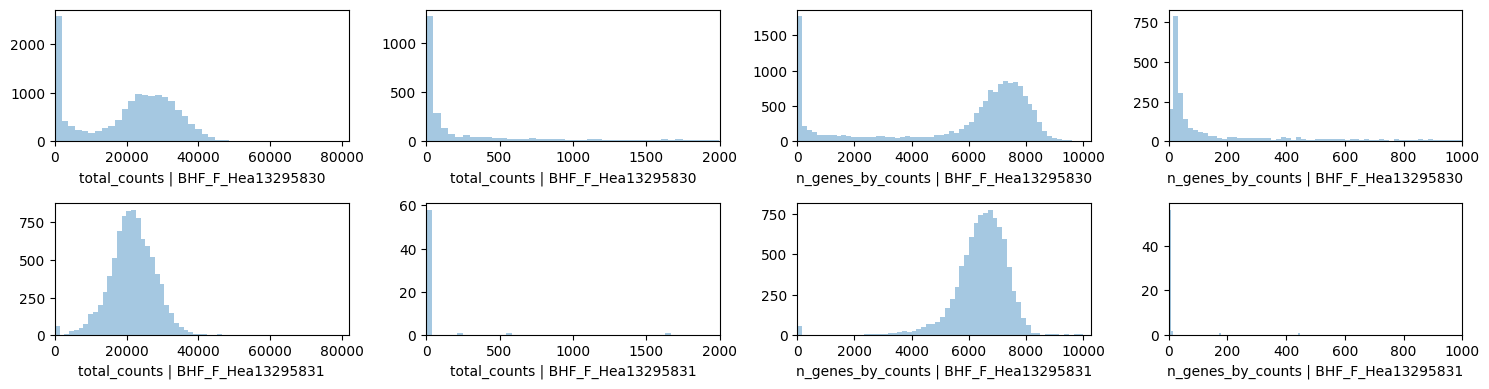

In [12]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i, s in enumerate(adata_vis.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')

    slide = select_slide(adata_vis, s)
    sns.distplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata_vis.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<2000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 2000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata_vis.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<1000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 1000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

## Filter out low quality spots

In [13]:
# filter out low quality spots
sc.pp.filter_cells(adata_vis, min_counts = 500)
sc.pp.filter_cells(adata_vis, min_genes = 300)

# Spot number per slide
adata_vis.obs['sample'].value_counts()

BHF_F_Hea13295830    12280
BHF_F_Hea13295831     8899
Name: sample, dtype: int64

## Remove mitochondrial genes

In [14]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
print(sum(adata_vis.var['MT_gene']))
    
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]
print(sum(adata_vis.var['MT_gene']))

11
0


In [15]:
meta.head()

,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed,status,cell2loc-map_group
Publication,,,,,,,,,,,,,,,
Foetal,BHF_F_Hea13295830,na,Hst45,na,Heart,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW
Foetal,BHF_F_Hea13295831,na,Hst45,na,Heart,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW


## Add metadata and annotation

In [16]:
adata_vis.obs = adata_vis.obs.reset_index().merge(meta, how='left', left_on='sample', right_on='sangerID').set_index('spot_id')
adata_vis

AnnData object with n_obs × n_vars = 21179 × 18074
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts-BHF_F_Hea13295830', 'mean_counts-BHF_F_Hea13295830', 'log1p_mean_counts-BHF_F_Hea13295830', 'pct_dropout_by_counts-BHF_F_Hea13295830', 'total_counts-BHF_F_Hea13295830', 'log1p_total_counts-BHF_F_Hea13295830', 'n_cells_by_counts-BHF_F_Hea13295831', 'mean_counts-BHF_F_Hea13295831', 'log1p_mean_counts-BHF_F_Hea13295831', 'pct_dropout_by_counts-BHF_F_Hea13295831', 'total_counts-

In [17]:
adata_vis.obs.head()

,in_tissue,array_row,array_col,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,...,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed,status,cell2loc-map_group
spot_id,,,,,,,,,,,,,,,,,,,,,
BHF_F_Hea13295830_AACAATCCGAGTGGAC-1,1,103,47,BHF_F_Hea13295830,8008,8.988321,34894.0,10.460099,25.626182,30.005158,...,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW
BHF_F_Hea13295830_AACAATGGAACCACAT-1,1,54,32,BHF_F_Hea13295830,5740,8.655389,21502.0,9.975947,39.359129,43.819180,...,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW
BHF_F_Hea13295830_AACAATGTGCTCCGAG-1,1,98,158,BHF_F_Hea13295830,7175,8.878497,24622.0,10.111436,22.861668,27.390139,...,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW
BHF_F_Hea13295830_AACACCAGCCTACTCG-1,1,31,39,BHF_F_Hea13295830,6147,8.723882,15342.0,9.638414,19.743189,23.992961,...,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW
BHF_F_Hea13295830_AACACCATTCGCATAC-1,1,53,139,BHF_F_Hea13295830,7008,8.854950,25862.0,10.160568,27.101539,31.405150,...,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW


In [18]:
# annotation
path_to_annot='/nfs/team205/heart/visium_annotations/foetal'
category_name='JC_edit'

# read in annotation csv file and concatenate
for i, ID in enumerate(sampleIDs):
    if f'{ID}_JC.csv' in os.listdir(path_to_annot):
    
        print(ID)
        annot_df = pd.read_csv(f'{path_to_annot}/{ID}_JC.csv')
        annot_df['spot_id']=ID+'_'+annot_df['Barcode']

        if i==0:
            annot_df_all=annot_df.copy()
        else:
            annot_df_all=pd.concat([annot_df_all,annot_df])
    else:
        print(f'{ID} is not annotated')

# add annotations to adata_vis
adata_vis.obs=pd.concat([adata_vis.obs,
                     annot_df_all.set_index('spot_id')[[category_name]].reindex(adata_vis.obs.index)],
                     axis=1)
# replace nan to 'none'
adata_vis.obs[category_name].fillna('none', inplace=True)

# minor modification
annotation_edit_dict = {
     'AV Ring':'AV ring',
    'Aorta':'Great vessels',
    'Coronary Artery':'Coronary artery',
    'Mitral Valve':'AV valves',
    'Mitral valve':'AV valves',
    'Myocardium - Ventricular - Trabecular':'Myocardium - Ventricular - Trabeculated',
    'Myocardim - Ventricular - Trabeculated':'Myocardium - Ventricular - Trabeculated',
    'Myocardim - Ventricular - Compact':'Myocardium - Ventricular - Compact',
    'unknown':'Unannotated',
    'Unknown':'Unannotated',
}
adata_vis.obs.replace({category_name:annotation_edit_dict}, inplace=True)
set(adata_vis.obs[category_name])

BHF_F_Hea13295830
BHF_F_Hea13295831


{'AV ring',
 'AV valves',
 'AVN',
 'Aortic valve',
 'Bundle branch - left',
 'Bundle branch - right',
 'Cavity',
 'Connective tissue',
 'Coronary artery',
 'Epicardium',
 'Great vessels',
 'Great vessels ',
 'LN',
 'Myocardium - Atrial',
 'Myocardium - Papillary Muscle',
 'Myocardium - Ventricular - Compact',
 'Myocardium - Ventricular - Compact 1',
 'Myocardium - Ventricular - Trabeculated',
 'Valve apparatus'}

## Remove spots based on manual annotation

In [19]:
# remove 'none' and 'no_tissue'
adata_vis = adata_vis[adata_vis.obs[category_name].isin(['none','Out_of_tissue'])==False]

# remove 'Cavity'
adata_vis = adata_vis[adata_vis.obs[category_name].isin(['Cavity'])==False]

# remove 'Unannotated'
adata_vis = adata_vis[adata_vis.obs[category_name].isin(['Unannotated'])==False]

In [20]:
# order annotations
annotations_order = ['Myocardium - Atrial',
                     'Myocardium - Ventricular - Compact',
                     'Myocardium - Ventricular - Trabeculated',
                    'Myocardium - Papillary Muscle',
                    'Epicardium',
                     'AV valves',
                     'Aortic valve',
                    'Valve apparatus',
                   'AV ring',
                    'Connective tissue',
                     'Great vessels',
                     'Coronary artery',
                     # 'Nerve',
                     ]
#adata_vis.obs[category_name] = adata_vis.obs[category_name].astype('category')
#adata_vis.obs[category_name].cat.reorder_categories(annotations_order,inplace=True)

In [21]:
pd.crosstab(adata_vis.obs['cell2loc-map_group'],adata_vis.obs[category_name])

JC_edit,AV ring,AV valves,AVN,Aortic valve,Bundle branch - left,Bundle branch - right,Connective tissue,Coronary artery,Epicardium,Great vessels,Great vessels,LN,Myocardium - Atrial,Myocardium - Papillary Muscle,Myocardium - Ventricular - Compact,Myocardium - Ventricular - Compact 1,Myocardium - Ventricular - Trabeculated,Valve apparatus
cell2loc-map_group,,,,,,,,,,,,,,,,,,
FFPE_16PCW,158,403,34,152,31,64,1217,114,135,506,216,20,2045,100,8914,60,5278,300


## Combine pcw13w-Atrial and pcw13w-Ventricle data to have whole heart in one sample

In [22]:
# check the slides for 'PCW-13w'
#mask = adata_vis.obs['age']=='PCW-13w'
#adata_vis[mask].obs['sample'].value_counts()
# 'HCAHeartST11605166': Atrium
# 'HCAHeartST11605165': Ventricle

In [23]:
# combine
adata_vis.obs['sample_for_cell2loc']=adata_vis.obs['sample'].astype('str')
#adata_vis.obs.replace({'sample_for_cell2loc':{
#    'HCAHeartST11605165':'HCAHeartST11605165_HCAHeartST11605166',
#    'HCAHeartST11605166':'HCAHeartST11605165_HCAHeartST11605166'
#}},inplace=True)
adata_vis.obs['sample_for_cell2loc'].value_counts()

/tmp/ipykernel_1547584/283590942.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_vis.obs['sample_for_cell2loc']=adata_vis.obs['sample'].astype('str')


BHF_F_Hea13295830    10848
BHF_F_Hea13295831     8899
Name: sample_for_cell2loc, dtype: int64

In [24]:
adata_vis.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac',
       'n_counts', 'n_genes', 'sangerID', 'combinedID', 'donor', 'donor_type',
       'region', 'region_finest', 'age', 'gender', 'facility',
       'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status',
       'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc'],
      dtype='object')

In [25]:
set(meta['cell2loc-map_group'])

{'FFPE_16PCW'}

## Run per group: cell2location mapping

In [26]:
# convert adata_vis.var_names to gene_id
adata_vis.var.set_index('gene_ids',inplace=True)
adata_vis.var.head()

,feature_types,genome,SYMBOL,mt,n_cells_by_counts-BHF_F_Hea13295830,mean_counts-BHF_F_Hea13295830,log1p_mean_counts-BHF_F_Hea13295830,pct_dropout_by_counts-BHF_F_Hea13295830,total_counts-BHF_F_Hea13295830,log1p_total_counts-BHF_F_Hea13295830,n_cells_by_counts-BHF_F_Hea13295831,mean_counts-BHF_F_Hea13295831,log1p_mean_counts-BHF_F_Hea13295831,pct_dropout_by_counts-BHF_F_Hea13295831,total_counts-BHF_F_Hea13295831,log1p_total_counts-BHF_F_Hea13295831,MT_gene
gene_ids,,,,,,,,,,,,,,,,,
ENSG00000187634,Gene Expression,GRCh38,SAMD11,False,2316,0.219936,0.198798,83.844866,3153.0,8.056427,1191,0.162983,0.150988,86.704622,1460.0,7.286877,False
ENSG00000188976,Gene Expression,GRCh38,NOC2L,False,6940,0.832868,0.605882,51.590402,11940.0,9.387733,4543,0.765126,0.568222,49.285555,6854.0,8.832733,False
ENSG00000187961,Gene Expression,GRCh38,KLHL17,False,1260,0.094866,0.090632,91.210938,1360.0,7.215975,617,0.071668,0.069216,93.112302,642.0,6.466145,False
ENSG00000187583,Gene Expression,GRCh38,PLEKHN1,False,149,0.010463,0.010409,98.960658,150.0,5.017280,155,0.017415,0.017265,98.269703,156.0,5.056246,False
ENSG00000187642,Gene Expression,GRCh38,PERM1,False,189,0.013323,0.013235,98.681641,191.0,5.257495,125,0.013954,0.013858,98.604599,125.0,4.836282,False


In [27]:
adata_vis.obs.head(3)

,in_tissue,array_row,array_col,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,...,gender,facility,cell_or_nuclei,modality,kit_10x,flushed,status,cell2loc-map_group,JC_edit,sample_for_cell2loc
spot_id,,,,,,,,,,,,,,,,,,,,,
BHF_F_Hea13295830_AACAATCCGAGTGGAC-1,1,103,47,BHF_F_Hea13295830,8008,8.988321,34894.0,10.460099,25.626182,30.005158,...,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW,Myocardium - Ventricular - Compact,BHF_F_Hea13295830
BHF_F_Hea13295830_AACAATGGAACCACAT-1,1,54,32,BHF_F_Hea13295830,5740,8.655389,21502.0,9.975947,39.359129,43.819180,...,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW,Great vessels,BHF_F_Hea13295830
BHF_F_Hea13295830_AACAATGTGCTCCGAG-1,1,98,158,BHF_F_Hea13295830,7175,8.878497,24622.0,10.111436,22.861668,27.390139,...,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW,Myocardium - Ventricular - Trabeculated,BHF_F_Hea13295830


(13904, 64)
####### FFPE_16PCW #######
samples in this run: ['BHF_F_Hea13295830', 'BHF_F_Hea13295831']


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [

Epoch 20000/20000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [47:34<00:00,  6.62it/s, v_num=1, elbo_train=2.96e+8]

`Trainer.fit` stopped: `max_epochs=20000` reached.


Epoch 20000/20000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [47:34<00:00,  7.01it/s, v_num=1, elbo_train=2.96e+8]


Anndata setup with scvi-tools version 0.20.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample_for_cell2loc',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 19747 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 13904 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                             batch State Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃         Source Location          ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample_for_cell2loc'] │ BHF_F_Hea13295830 │          0          │
│                                  │ BHF_F_Hea13295831 │          1          │
└──────────────────────────────────┴───────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:25<00:00, 39.42it/s]


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/cell2location/models/base/_pyro_mixin.py:407: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


CPU times: user 50min 37s, sys: 30.9 s, total: 51min 8s
Wall time: 51min 8s


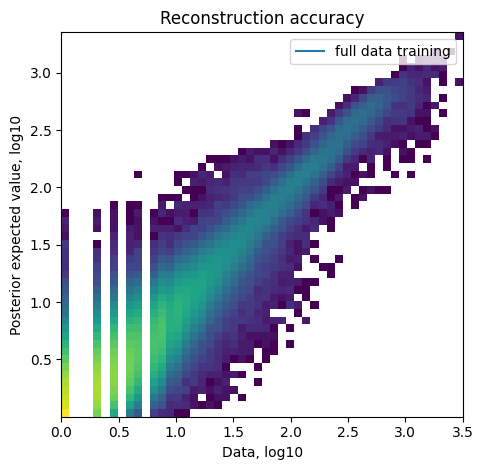

In [28]:
%%time
import cell2location
# read in reference signatures
inf_aver = pd.read_csv(f"{ref_run_name}/all_data/inf_aver.csv", index_col=0)

# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
print(inf_aver.shape)

for group in set(meta['cell2loc-map_group']):
    print(f'####### {group} #######')
    
    # subset adata
    adata_vis_sub=adata_vis[adata_vis.obs['cell2loc-map_group']==group].copy()
    samples = list(set(adata_vis_sub.obs['sample_for_cell2loc']))
    samples.sort()
    print(f'samples in this run: {samples}')
    adata_vis_sub=adata_vis_sub.copy()
    # prepare anndata for cell2location model
    cell2location.models.Cell2location.setup_anndata(adata=adata_vis_sub, batch_key="sample_for_cell2loc")
    #scvi.data.setup_anndata(adata=adata_vis_sub, batch_key="sample_for_cell2loc")
    #scvi.data.view_anndata_setup(adata_vis_sub)

    # create and train the model
    mod = cell2location.models.Cell2location(
        adata_vis_sub, cell_state_df=inf_aver, 
        # the expected average cell abundance: tissue-dependent 
        # hyper-prior which can be estimated from paired histology:
        N_cells_per_location=20,
        # hyperparameter controlling normalisation of
        # within-experiment variation in RNA detection (using default here):
        detection_alpha=20
    ) 

    mod.train(max_epochs=20000, 
              # train using full data (batch_size=None)
              batch_size=None, 
              # use all data points in training because 
              # we need to estimate cell abundance at all locations
              train_size=1,
              use_gpu=True)
    mod.view_anndata_setup()
    # plot ELBO loss history during training, removing first 100 epochs from the plot
    mod.plot_history(1000)
    plt.legend(labels=['full data training']);

    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_vis_sub = mod.export_posterior(
        adata_vis_sub, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
    )

    # Save model
    mod.save(f"{run_name}/{group}", overwrite=True)

    # Save anndata object with results
    adata_vis_sub.write(f"{run_name}/{group}/sp.h5ad")

    # Examine reconstruction accuracy to assess if there are any issues with mapping
    # the plot should be roughly diagonal, strong deviations will signal problems
    mod.plot_QC()
    
    del mod,adata_vis_sub
    gc.collect()
    torch.cuda.empty_cache()